In [2]:
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

dataset = json.load(open('datasets/dataset.json'))
 
totaltweets = 0
totalusers = len(dataset)
totalrt = 0
userlist = list()
realusers = list()

usernames = list()
for user in dataset:
    userlist.append(user['handle'])
    realusers.append(user['handle'])
    totaltweets = totaltweets + len(user['tweets'])
    for tweet in user['tweets']:
        realusers.append(list(tweet['retweeted_from'].keys())[0])

print("Are there user duplicates in the list? "+str(len(userlist) != len(set(userlist))))
print("We have a total of "+str(totalusers)+" users and "+str(totaltweets)+" retweets.")
print("We calculate around "+str(totaltweets/totalusers)+" tweets per user.")

realusers = list(dict.fromkeys(realusers))
print("Total unique users (OC+RT) detected: "+str(len(realusers)))

Are there user duplicates in the list? False
We have a total of 35682 users and 127461 retweets.
We calculate around 3.5721372120396837 tweets per user.
Total unique users (OC+RT) detected: 40347


In [3]:
print("Generating edge list...", end=" ")
twitter_d = nx.DiGraph()
for user in dataset:
    username = user['handle']
    for tweet in user['tweets']:
        rt_oc_user = list(tweet['retweeted_from'].keys())[0]
        link = (username,rt_oc_user)
        if username == rt_oc_user:
            continue #User is retweeting himself; avoid self-loops
        if (twitter_d.has_edge(username, rt_oc_user) != True):
            twitter_d.add_edge(username, rt_oc_user, weight=1)
        else:
            twitter_d[username][rt_oc_user]['weight'] += 1
print("Done.")
print('Preformatted nodes: {}'.format(twitter_d.order()))

print('Removing nodes outside of Giant Component...', end='')
weak_nodes = max(nx.weakly_connected_components(twitter_d), key=len)
nodelist = list()
for n in twitter_d.nodes():
    if n not in weak_nodes:
      nodelist.append(n)
twitter_d.remove_nodes_from(nodelist)
print(' '+str(len(nodelist))+ ' nodes removed.')

print('Number of nodes: {}'.format(twitter_d.order()))
print('Number of links: {}'.format(twitter_d.size()))
density = nx.density(twitter_d)
print('Density: {}'.format(density))

Generating edge list... Done.
Preformatted nodes: 40261
Removing nodes outside of Giant Component... 3315 nodes removed.
Number of nodes: 36946
Number of links: 84807
Density: 6.213103721248901e-05


In [4]:
degree = list(dict(twitter_d.degree()).values())
in_degree = list(dict(twitter_d.in_degree()).values())
out_degree = list(dict(twitter_d.out_degree()).values())
print('Mean degree: {}'.format(np.mean(degree)))
print('Standard deviation: {}'.format(np.std(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))

Mean degree: 4.590862339630813
Standard deviation: 39.90866849325069
Median: 1.0
Min: 1
Max: 6032


In [5]:
print('Mean in-degree: {}'.format(np.mean(in_degree)))
print('Standard deviation: {}'.format(np.std(in_degree)))
print('Median: {}'.format(np.median(in_degree)))
print('Min: {}'.format(np.min(in_degree)))
print('Max: {}'.format(np.max(in_degree)))

Mean in-degree: 2.2954311698154064
Standard deviation: 39.66301453828775
Median: 0.0
Min: 0
Max: 6032


In [6]:
print('Mean out-degree: {}'.format(np.mean(out_degree)))
print('Standard deviation: {}'.format(np.std(out_degree)))
print('Median: {}'.format(np.median(out_degree)))
print('Min: {}'.format(np.min(out_degree)))
print('Max: {}'.format(np.max(out_degree)))

Mean out-degree: 2.2954311698154064
Standard deviation: 4.215177935178007
Median: 1.0
Min: 0
Max: 198


Text(0, 0.5, 'ECDF')

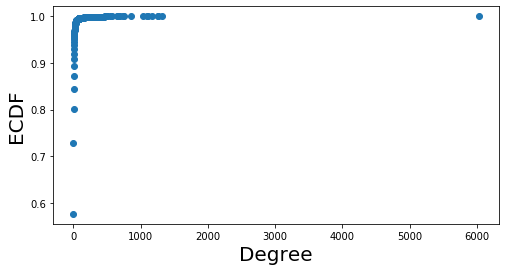

In [7]:
# ECDF linear scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(8,4))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=6, linestyle='None')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECDF', size = 20)

Text(0, 0.5, 'ECDF')

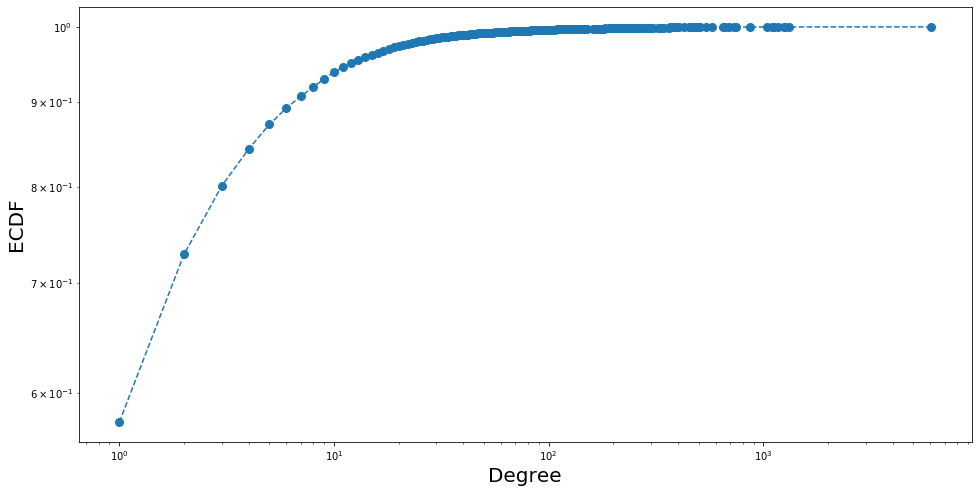

In [8]:
# ECDF loglog scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,y,marker='o',ms=8, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECDF', size=20)

Text(0, 0.5, 'ECCDF')

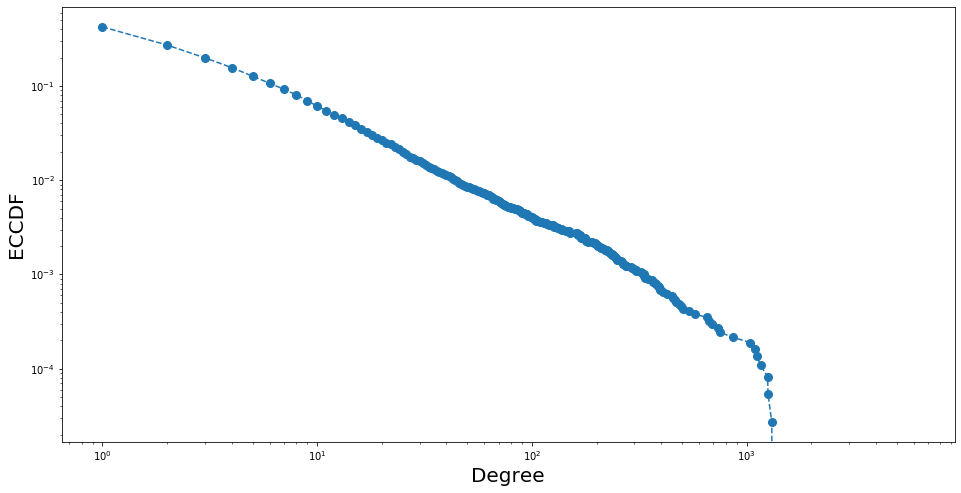

In [9]:
# ECCDF
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size=20)

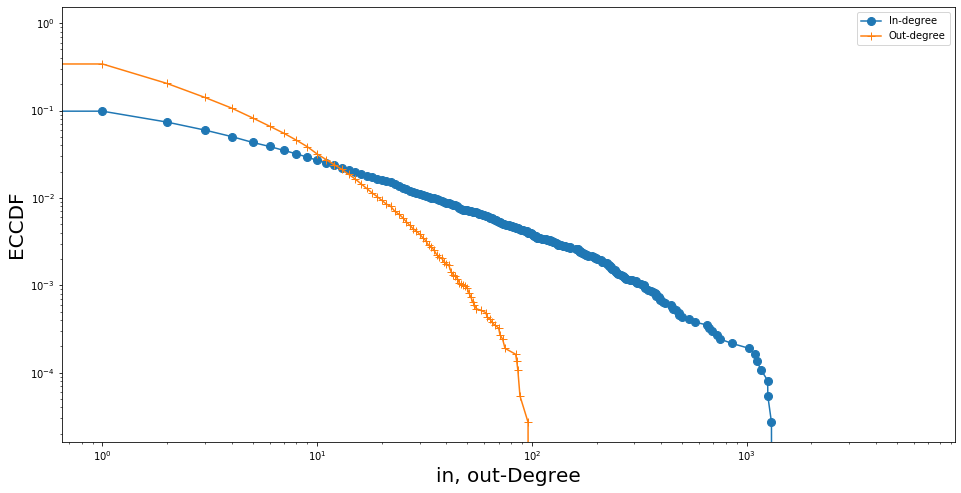

In [10]:
# ECCDF in-degree
cdf = ECDF(in_degree)
x = np.unique(in_degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8,label='In-degree')
cdf = ECDF(out_degree)
x = np.unique(out_degree)
y = cdf(x)
axes.loglog(x,1-y,marker='+',ms=8,label='Out-degree')
axes.set_xlabel('in, out-Degree',size=20)
axes.set_ylabel('ECCDF', size=20)
axes.legend()

In [11]:
percentile_99 = np.percentile(degree,99.9)
print(percentile_99)

332.05500000000757


In [12]:
hub_nodi = [k for k,v in dict(twitter_d.degree()).items() if v>= percentile_99]
print(len(hub_nodi))
print(list(hub_nodi))

37
['MediasetTgcom24', 'you_trend', 'Adnkronos', 'Agenzia_Ansa', 'RadioSavana', 'benq_antonio', 'TarroGiulio', 'VittorioSgarbi', 'SkyTG24', 'repubblica', 'MedicalFactsIT', 'Corriere', 'Pontifex_it', 'CesareSacchetti', 'IlariaBifarini', 'ItalyQanons', 'NonVaccinato', 'Stefbazzi', 'ilpost', 'francescatotolo', 'LaStampa', 'matteosalvinimi', 'GiorgiaMeloni', 'DSantanche', 'giorgiamennuni', 'fattoquotidiano', 'molumbe', 'VNotKind', 'GiancarloDeRisi', 'matteorenzi', 'Cartabellotta', 'marco_gervasoni', 'jeperego', 'Pgreco_', 'GrimoldiPaolo', 'christianrocca', 'davcarretta']


In [15]:
degree=dict(nx.degree(twitter_d))
degree_centrality = nx.degree_centrality(twitter_d)
closeness_centrality = nx.closeness_centrality(twitter_d)
eigenvector_centrality = nx.eigenvector_centrality(twitter_d)

# lambda function or anonimous function. no name, no return, no def, just use the keyword lambda
# Sintax: lambda argument: manipulate(argument)
hub_degree = sorted(degree_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_closeness = sorted(closeness_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_eigenvector = sorted(eigenvector_centrality.items(),key = lambda x:x[1], reverse=True)[0]
print('degree:      ',hub_degree)
print('closeness:   ',hub_closeness)
print('eigenvector: ',hub_eigenvector)

degree:       ('RadioSavana', 0.1632697252672892)
closeness:    ('RadioSavana', 0.08487170409446092)
eigenvector:  ('RadioSavana', 0.6272093284012229)


In [28]:
print('Beware: betweenness centrality is valued for approximately 10% of the network, due to the sheer time needed for the calculation.')
betweenness_centrality=nx.betweenness_centrality(twitter_d, k=3600)
hub_betweenness = sorted(betweenness_centrality.items(),key = lambda x:x[1], reverse=True)[0]
print('betweenness: ',hub_betweenness)

betweenness:  ('Paolorm2012Roma', 0.003394127262866531)


In [32]:
print('Transitivity: {}'.format(nx.transitivity(twitter_d)))
print('Clustering: {}'.format(nx.clustering(twitter_d)))

Transitivity: 0.030538634596011003
